# Titanic Disaster


<img src = "https://drive.google.com/uc?id=1N8r3PEw9q8xaVdeWx_4GgB6cmAGugxRr" width="500" >


## Import Libraries

In [1]:
## ----- BASIC LIBRARIES ------

import pandas as pd # Dataframe operations
import matplotlib.pyplot as plt # Plots
import seaborn as sns # Improve plots
import opendatasets as od # Download data from Kaggle
import missingno as msno # Looking for nan values
from collections import Counter # Counter tool
import numpy as np # Array operations

## ----- PREPROCESSING ------

from sklearn.impute import KNNImputer # Imputer tool base on KNN
from sklearn.model_selection import train_test_split # Split data into train and test
from sklearn.preprocessing import StandardScaler # Scaler tool

## ----- PROCESSING -----

# Import models 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

## ----- POSTPROCESSING -----
import optuna # Hyperparameters Tuning
from imblearn.over_sampling import SMOTE # Balancing data

In [2]:
# Set the display format for pandas tables
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Let's download the data directly from [Kaggle Competition Website](https://www.kaggle.com/competitions/titanic/data)

In [3]:
# Download using opendatasets library
od.download("https://www.kaggle.com/c/titanic")

Skipping, found downloaded files in ".\titanic" (use force=True to force download)


In [4]:
# Read the train dataframe

df_titanic = pd.read_csv("titanic/train.csv")
df_titanic.head() # Show first 5 rows of the data frame

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex    Age  SibSp  \
0                            Braund, Mr. Owen Harris    male 22.000      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1   
2                             Heikkinen, Miss. Laina  female 26.000      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.000      1   
4                           Allen, Mr. William Henry    male 35.000      0   

   Parch            Ticket   Fare Cabin Embarked  
0      0         A/5 21171  7.250   NaN        S  
1      0          PC 17599 71.283   C85        C  
2      0  STON/O2. 3101282  7.925   NaN        S  
3      0            113803 53.100  C123        S  
4      0            373450  8.050   NaN        S

In [5]:
# Number of rows and columns

df_titanic.shape

(891, 12)

There is data of **891** passengers. The data has **12** columns.

In [6]:
# Get the info fot the dataframe columns

df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are **2** columns with *float* data, **5** columns with *int* data, and **5** columns with *object/string* data.

There are missing values in the *Age*, *Cabin* and *Embarked* columns.

In [7]:
# Describe the numeric (int & float) columns 

df_titanic.describe()

PassengerId  Survived  Pclass     Age   SibSp   Parch    Fare
count      891.000   891.000 891.000 714.000 891.000 891.000 891.000
mean       446.000     0.384   2.309  29.699   0.523   0.382  32.204
std        257.354     0.487   0.836  14.526   1.103   0.806  49.693
min          1.000     0.000   1.000   0.420   0.000   0.000   0.000
25%        223.500     0.000   2.000  20.125   0.000   0.000   7.910
50%        446.000     0.000   3.000  28.000   0.000   0.000  14.454
75%        668.500     1.000   3.000  38.000   1.000   0.000  31.000
max        891.000     1.000   3.000  80.000   8.000   6.000 512.329

In [8]:
# Describe the string/object columns

df_titanic.describe(include = "O")

Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      204      889
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7        4      644

We can use [missingno](https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009) to visualise the missing values

<AxesSubplot:>

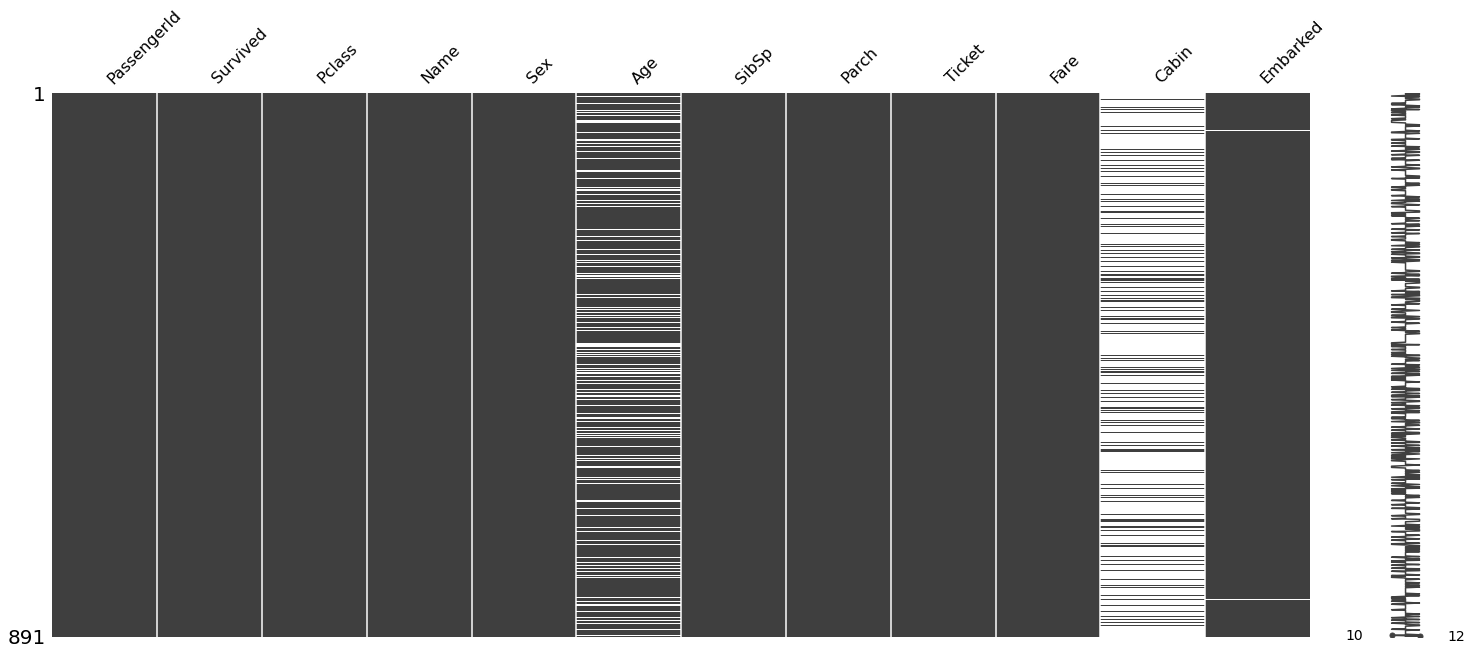

In [9]:
msno.matrix(df_titanic)

We can compute the percentage of NaN values in each column.

In [10]:
(df_titanic.isna().sum()/len(df_titanic)*100).to_frame().rename(columns = {0:"Missing Values[%]"})

Missing Values[%]
PassengerId              0.000
Survived                 0.000
Pclass                   0.000
Name                     0.000
Sex                      0.000
Age                     19.865
SibSp                    0.000
Parch                    0.000
Ticket                   0.000
Fare                     0.000
Cabin                   77.104
Embarked                 0.224

*Cabin* column has more the 70% of missing values, so it must be deleted from the dataframe. On the other hand, *Age* and *Embarked* columns have less than 20% of missing values, we can use imputation techniques to complete the data.

*PassengerID* column is just the positional value of each passenger into the dataframe, so it will be deleted.
*Name* column is just a string, it could be used in future analysis using **Feature Engineering**, but in this case it will be deleted, in order to simplify the analysis.

In [11]:
df_titanic.drop(["PassengerId", "Name", "Cabin"], axis = 1, inplace = True) # Delete columns

df_titanic.head()

Survived  Pclass     Sex    Age  SibSp  Parch            Ticket   Fare  \
0         0       3    male 22.000      1      0         A/5 21171  7.250   
1         1       1  female 38.000      1      0          PC 17599 71.283   
2         1       3  female 26.000      0      0  STON/O2. 3101282  7.925   
3         1       1  female 35.000      1      0            113803 53.100   
4         0       3    male 35.000      0      0            373450  8.050   

  Embarked  
0        S  
1        C  
2        S  
3        S  
4        S

Let's plot some data

Firstly, quantitative data: **Age** and **Fare**

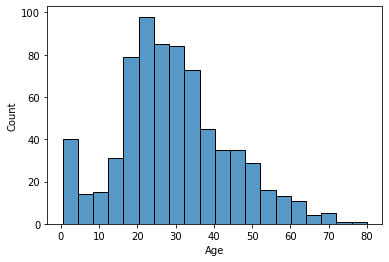

In [12]:
sns.histplot(df_titanic["Age"])
plt.show()

Passengers' Age were between 0 an 80 years, but most of them were young adults.

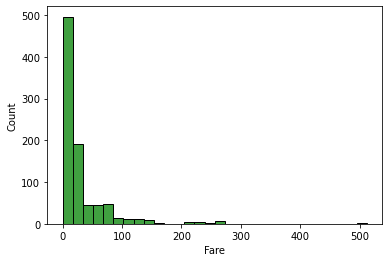

In [13]:
sns.histplot(df_titanic["Fare"], color = "g", bins  = 30)
plt.show()

Most of the Fare were below \\$100. However, some people paid more than \\$200 and even more than \\$500.

Now let's plot the categorical variables: **Survived**, **Pclass**, **SibSp**, **Parch**, **Sex**, and **Embarked**

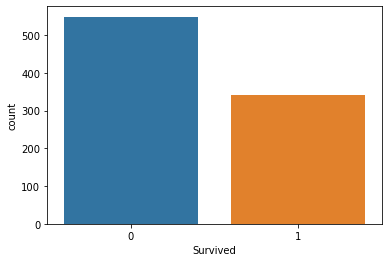

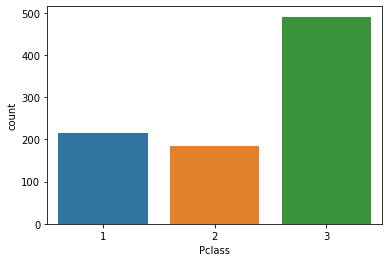

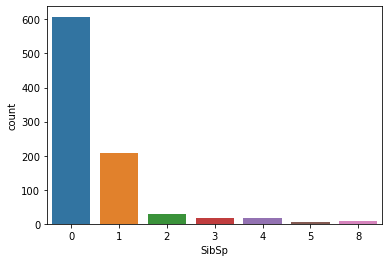

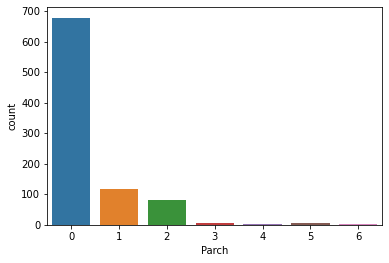

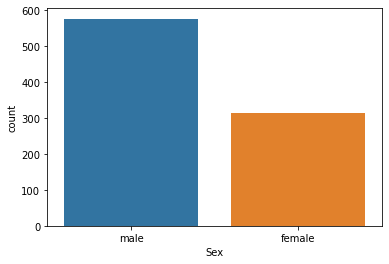

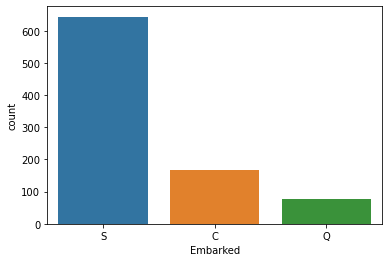

In [14]:
cate = ["Survived", "Pclass", "SibSp", "Parch", "Sex", "Embarked"]

for i in cate:
    sns.countplot(data = df_titanic, x = i)
    plt.show()

We can notice the following:
* Most of people died.
* The label column (Survived) is unbalanced. This can affect the predictive model performance.
* Most of people belonged to third class.
* Most of people traveled alone. 
* Most of people were male
* Most of people embarked in Southampton

Now we can plot pairwise relationships between the numerical values into the dataset.

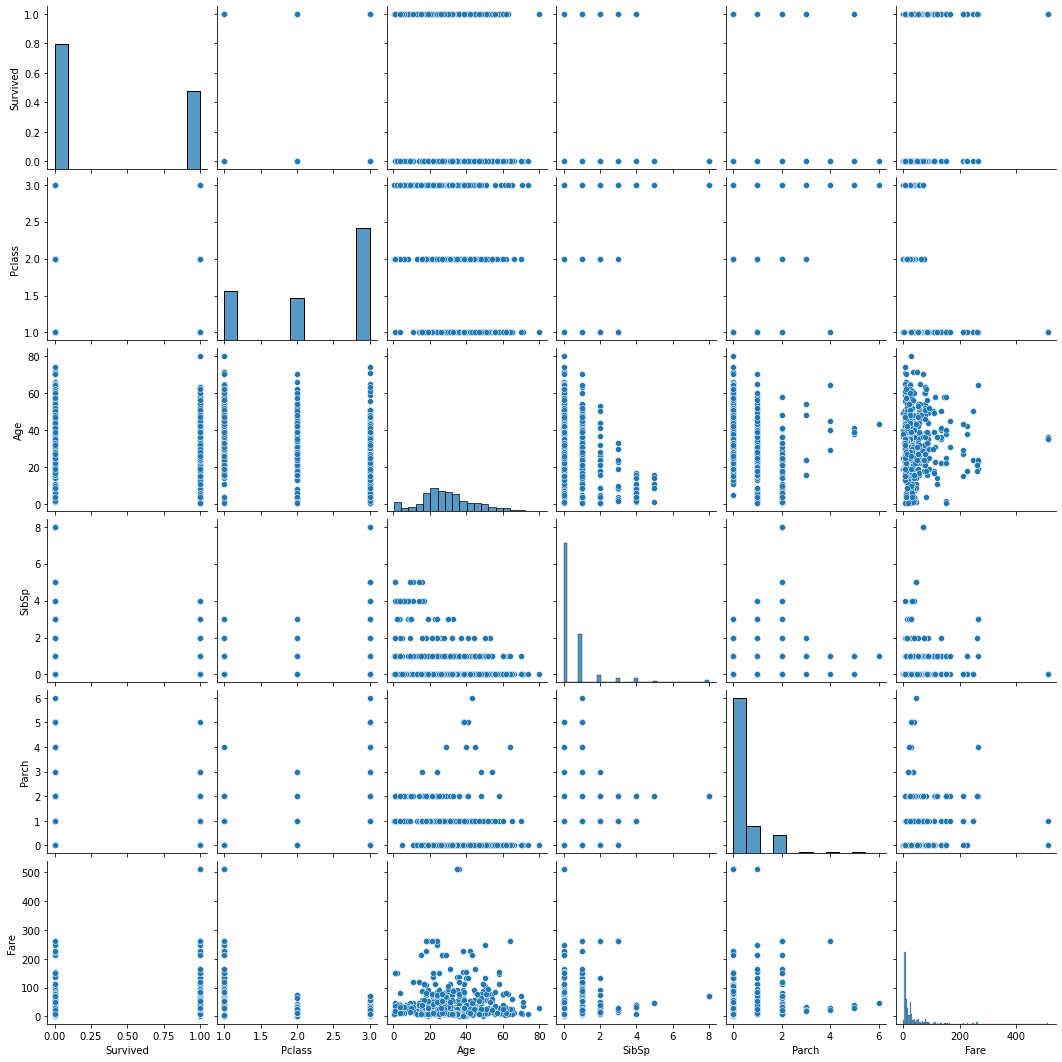

In [15]:
sns.pairplot(data = df_titanic)
plt.show()

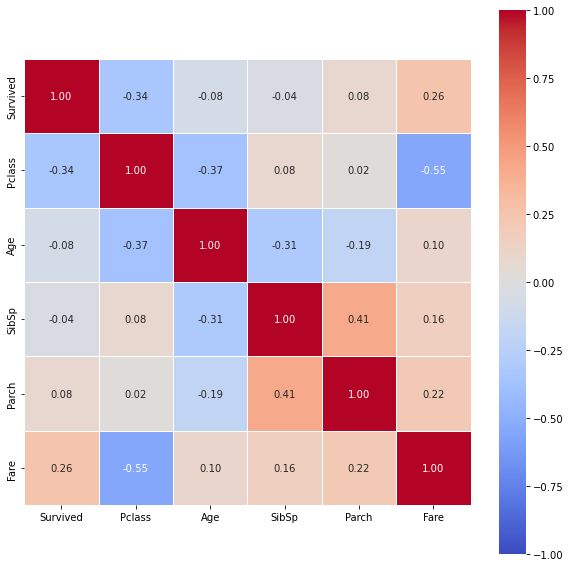

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_titanic.corr(method = "pearson"), vmin = - 1, vmax = 1, center = 0, fmt='.2f',
                square = True, linewidths = 0.5, annot = True, cmap = 'coolwarm')
plt.show()

There is not an strong correlation among variables. However, there is a *moderate negative* correlation between **Fare** and **Pclass**, which make sense because the first class (1) had a higher cost.

Now, let´s analyse some data realted to the output variable **Survived**

In [17]:
pd.pivot_table(df_titanic, index = "Survived", values = ["Age", "Fare"])

Age   Fare
Survived              
0        30.626 22.118
1        28.344 48.395

The average age of survivors was 28 years and most of survivors paied more for the ticket, so we can relate the chance to survive with First Class

In [18]:
df_titanic[["Survived", "Pclass"]].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Pclass  Survived
0       1     0.630
1       2     0.473
2       3     0.242

Base on the odds to survive, we can see that if you were in First class your chance of survival was around 63% compared with the Third class travelers which had 24%.

In [19]:
df_titanic[["Survived", "SibSp"]].groupby(['SibSp'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

SibSp  Survived
1      1     0.536
2      2     0.464
0      0     0.345
3      3     0.250
4      4     0.167
5      5     0.000
6      8     0.000

If you traveled without Siblings of Spouses your chances of survival were higher.

In [20]:
df_titanic[["Survived", "Embarked"]].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Embarked  Survived
0        C     0.554
1        Q     0.390
2        S     0.337

If you embarked in Cherbourg your chances of survival were higher.

In [21]:
df_titanic[["Survived", "Sex"]].groupby(['Sex'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Sex  Survived
0  female     0.742
1    male     0.189

If you were a woman your chances of survival were higher. *Women and children first*

Now let's analyse the **Ticket** Column

In [22]:
df_ticket = df_titanic[["Survived","Ticket"]]
df_ticket

Survived            Ticket
0           0         A/5 21171
1           1          PC 17599
2           1  STON/O2. 3101282
3           1            113803
4           0            373450
..        ...               ...
886         0            211536
887         1            112053
888         0        W./C. 6607
889         1            111369
890         0            370376

[891 rows x 2 columns]

The Ticket Code was not standard. For some passengers this code was a number while for others were an alphanumeric codes. Let's classify them

In [23]:
df_ticket["Number"] = df_ticket["Ticket"].apply(lambda x: 1 if x.isnumeric() else 0)
df_ticket

C:\Users\acast\AppData\Local\Temp\ipykernel_20856\3385365277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket["Number"] = df_ticket["Ticket"].apply(lambda x: 1 if x.isnumeric() else 0)


Survived            Ticket  Number
0           0         A/5 21171       0
1           1          PC 17599       0
2           1  STON/O2. 3101282       0
3           1            113803       1
4           0            373450       1
..        ...               ...     ...
886         0            211536       1
887         1            112053       1
888         0        W./C. 6607       0
889         1            111369       1
890         0            370376       1

[891 rows x 3 columns]

In [24]:
df_ticket[["Survived", "Number"]].groupby(['Number'], as_index = False).mean().sort_values(by ='Survived', ascending = False)

Number  Survived
1       1     0.384
0       0     0.383

The is not a correlation between the type of ticket code (numeric or alphanumeric) with chances of survival. So based on this and the lack of uniformity for the codes we can drop this column.

In [25]:
df_titanic.drop("Ticket", axis = 1, inplace = True)
df_titanic.head()

Survived  Pclass     Sex    Age  SibSp  Parch   Fare Embarked
0         0       3    male 22.000      1      0  7.250        S
1         1       1  female 38.000      1      0 71.283        C
2         1       3  female 26.000      0      0  7.925        S
3         1       1  female 35.000      1      0 53.100        S
4         0       3    male 35.000      0      0  8.050        S

Next step will be deal with **missing values**

In [26]:
df_titanic.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

There were missing values in the **Age** and **Embarked** columns

**Embarked** is an *Object* column, so we can use the **Mode** option to impute the missing values.

In [27]:
df_titanic["Embarked"].fillna(df_titanic["Embarked"].mode()[0], inplace = True)
df_titanic["Embarked"].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

For advance imputation methods it is necessary to create dummy variables for the categorial variables such as **Sex** and **Embarked**

In [28]:
df2 = pd.get_dummies(df_titanic, columns=["Sex", "Embarked"], drop_first = True)
df2.head()

Survived  Pclass    Age  SibSp  Parch   Fare  Sex_male  Embarked_Q  \
0         0       3 22.000      1      0  7.250         1           0   
1         1       1 38.000      1      0 71.283         0           0   
2         1       3 26.000      0      0  7.925         0           0   
3         1       1 35.000      1      0 53.100         0           0   
4         0       3 35.000      0      0  8.050         1           0   

   Embarked_S  
0           1  
1           0  
2           1  
3           1  
4           1

For this case we can use [KNN imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) for completing missing values using k-Nearest Neighbors.

In [29]:
imputer_KNN = KNNImputer(n_neighbors = 10, weights = 'uniform', metric = 'nan_euclidean')

In [30]:
df_KNN = pd.DataFrame(imputer_KNN.fit_transform(df2), columns = df2.columns)

Let's check for missing values

In [31]:
df_KNN.isna().any()

Survived      False
Pclass        False
Age           False
SibSp         False
Parch         False
Fare          False
Sex_male      False
Embarked_Q    False
Embarked_S    False
dtype: bool

Now we can do some Feature Engineering in order to reduce the complexity of the data based on the above information. Specifically, we can replace the **SibSp** and **Parch** columns with a single boolean column based on wether the passenger traveled alone.

In [32]:
df_KNN["SibSp"].value_counts()

0.000    608
1.000    209
2.000     28
4.000     18
3.000     16
8.000      7
5.000      5
Name: SibSp, dtype: int64

In [33]:
df_KNN["Parch"].value_counts()

0.000    678
1.000    118
2.000     80
5.000      5
3.000      5
4.000      4
6.000      1
Name: Parch, dtype: int64

Both **SibSp** and **Parch** columns have a lot of categories, so is a great idea replace them for a single boolean column.

In [34]:
df_KNN['Travel Alone'] = 0
df_KNN.loc[(df_KNN['SibSp'] + df_KNN['Parch']) == 0, 'Travel Alone'] = 1
df_KNN.head()

Survived  Pclass    Age  SibSp  Parch   Fare  Sex_male  Embarked_Q  \
0     0.000   3.000 22.000  1.000  0.000  7.250     1.000       0.000   
1     1.000   1.000 38.000  1.000  0.000 71.283     0.000       0.000   
2     1.000   3.000 26.000  0.000  0.000  7.925     0.000       0.000   
3     1.000   1.000 35.000  1.000  0.000 53.100     0.000       0.000   
4     0.000   3.000 35.000  0.000  0.000  8.050     1.000       0.000   

   Embarked_S  Travel Alone  
0       1.000             0  
1       0.000             0  
2       1.000             1  
3       1.000             0  
4       1.000             1

In [35]:
df_KNN[['Travel Alone', 'Survived']].groupby(['Travel Alone'], as_index=False).mean()

Travel Alone  Survived
0             0     0.506
1             1     0.304

We can confirm that the value of the **Travel Alone** Column is related with the chances of survival. Now we can drop the **SibSp** and **Parch** columns

In [36]:
df_KNN.drop(["SibSp", "Parch"], axis = 1, inplace = True)

Now we can the processed dataset

In [37]:
df = df_KNN.copy()
df

Survived  Pclass    Age   Fare  Sex_male  Embarked_Q  Embarked_S  \
0       0.000   3.000 22.000  7.250     1.000       0.000       1.000   
1       1.000   1.000 38.000 71.283     0.000       0.000       0.000   
2       1.000   3.000 26.000  7.925     0.000       0.000       1.000   
3       1.000   1.000 35.000 53.100     0.000       0.000       1.000   
4       0.000   3.000 35.000  8.050     1.000       0.000       1.000   
..        ...     ...    ...    ...       ...         ...         ...   
886     0.000   2.000 27.000 13.000     1.000       0.000       1.000   
887     1.000   1.000 19.000 30.000     0.000       0.000       1.000   
888     0.000   3.000 25.300 23.450     0.000       0.000       1.000   
889     1.000   1.000 26.000 30.000     1.000       0.000       0.000   
890     0.000   3.000 32.000  7.750     1.000       1.000       0.000   

     Travel Alone  
0               0  
1               0  
2               1  
3               0  
4               1  
..            ...  
886             1  
887             1  
888             0  
889             1  
890             1  

[891 rows x 8 columns]

Now we separate the *Input* variables to the *Output* column

In [38]:
x = df.drop(["Survived"], axis = 1)
x

Pclass    Age   Fare  Sex_male  Embarked_Q  Embarked_S  Travel Alone
0     3.000 22.000  7.250     1.000       0.000       1.000             0
1     1.000 38.000 71.283     0.000       0.000       0.000             0
2     3.000 26.000  7.925     0.000       0.000       1.000             1
3     1.000 35.000 53.100     0.000       0.000       1.000             0
4     3.000 35.000  8.050     1.000       0.000       1.000             1
..      ...    ...    ...       ...         ...         ...           ...
886   2.000 27.000 13.000     1.000       0.000       1.000             1
887   1.000 19.000 30.000     0.000       0.000       1.000             1
888   3.000 25.300 23.450     0.000       0.000       1.000             0
889   1.000 26.000 30.000     1.000       0.000       0.000             1
890   3.000 32.000  7.750     1.000       1.000       0.000             1

[891 rows x 7 columns]

In [39]:
y = df["Survived"].values
y[:10]

array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1.])

We split the data set with a test size of **25%**

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

There are a lot of range for the values of the **Age** and **Fare** columns, so it is necessaty to scale them. In this case, we use the [Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [41]:
scaler = StandardScaler()

In [42]:
x_train[["Age", "Fare"]] = scaler.fit_transform(x_train[["Age", "Fare"]])
x_train.head()

Pclass    Age   Fare  Sex_male  Embarked_Q  Embarked_S  Travel Alone
357   2.000  0.589 -0.376     0.000       0.000       1.000             1
721   3.000 -0.962 -0.494     1.000       0.000       1.000             0
332   1.000  0.589  2.410     1.000       0.000       1.000             0
257   1.000 -0.002  1.081     0.000       0.000       1.000             1
410   3.000 -0.275 -0.478     1.000       0.000       1.000             1

In [43]:
x_test[["Age", "Fare"]] = scaler.transform(x_test[["Age", "Fare"]])
x_test.head()

Pclass    Age   Fare  Sex_male  Embarked_Q  Embarked_S  Travel Alone
267   3.000 -0.372 -0.480     1.000       0.000       1.000             0
859   3.000  0.090 -0.491     1.000       0.000       0.000             1
588   3.000 -0.593 -0.475     1.000       0.000       1.000             1
241   3.000 -0.272 -0.327     0.000       1.000       0.000             0
207   3.000 -0.298 -0.262     1.000       0.000       0.000             1

Let's plot and compare the data before and after the scaling process.

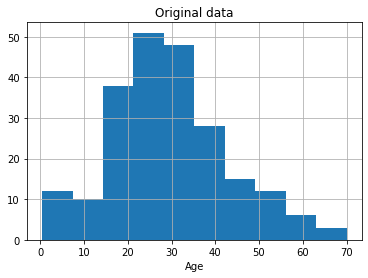

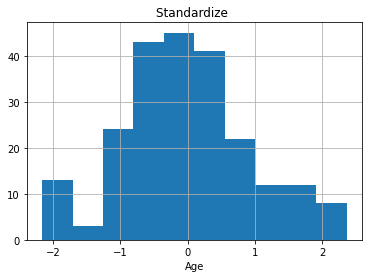

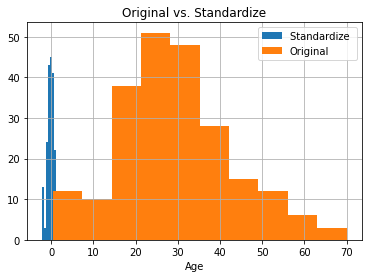

In [44]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size = 0.25, random_state = 0)

for i in range(3):
    if i == 0: # Originales
        x_test2["Age"].hist()
        plt.xlabel("Age")
        plt.title("Original data")
    elif  i == 1: # Estandarizados
        x_test["Age"].hist()
        plt.xlabel("Age")
        plt.title("Standardize ")
  
    else:
        x_test["Age"].hist(label = "Standardize ")
        x_test2["Age"].hist(label = "Original")
        plt.xlabel("Age")
        plt.title("Original vs. Standardize")
        plt.legend()
    plt.show()

The next step is to train the prediction models. We will compare the performance of the models with the train and test data to assess the overfitting and we will also use the confussion matrix to compare the classification process.

In [45]:
def modelo_clasificacion (modelo, x_train, y_train, x_test, y_test):
    m = modelo.fit(x_train, y_train)

    score_train = round(m.score(x_train, y_train) * 100, 2)
    score_test = round(m.score(x_test, y_test) *100, 2)
    cm = confusion_matrix(y_test, m.predict(x_test), labels = m.classes_)
    ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = m.classes_).plot()
    print(classification_report(y_test, m.predict(x_test), labels = m.classes_))

    return score_train, score_test

On the oher hand, a cross validation function is created to assess the general performance of the classification models based on the [f1-macro](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f) metric

In [46]:
def validacion_cruzada (modelo, x, y, metrica):
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)

    n_scores= cross_val_score(modelo, x, y, scoring = metrica, cv = cv, n_jobs = -1)

    media = np.mean(n_scores)
  
    COV = np.std(n_scores)/np.mean(n_scores)*100

    plt.plot(np.arange(1,len(n_scores)+1), n_scores, "o-", label = str(modelo))
    plt.axhline(media, color = "r", linestyle = "--")
    plt.legend(bbox_to_anchor=(1, 1))
  
    return media, COV

We will compare the performance of the following classification models:

1. Logistic Regression
2. K-Nearest-Neighbor
3. Naive Bayes Gaussian
4. Naive Bayes Bernoulli
5. Decision Tree Classifier
6. Random Forest Classifier
7. Extra Trees Classifier
8. Support Vector Classifier
9. XGBoost Classifier
10. Multilayer Perceptron Classifier

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84       141
         1.0       0.71      0.73      0.72        82

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



(80.99, 79.37)

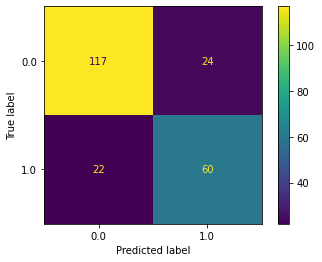

In [47]:
modelo_clasificacion(LogisticRegression(), x_train, y_train, x_test, y_test)

(0.7840536686555749, 5.822675333185899)

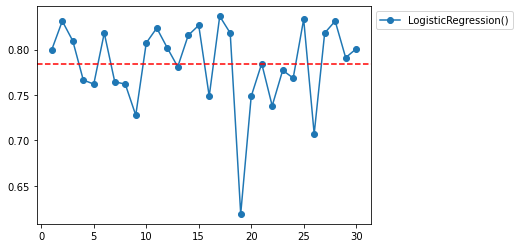

In [48]:
validacion_cruzada(LogisticRegression(), x, y, "f1_macro")

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       141
         1.0       0.75      0.72      0.73        82

    accuracy                           0.81       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.81      0.81      0.81       223



(85.63, 80.72)

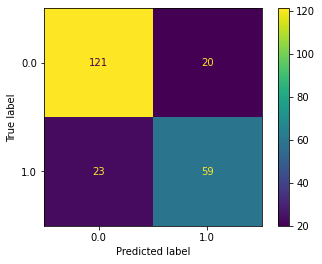

In [49]:
modelo_clasificacion(KNeighborsClassifier(), x_train, y_train, x_test, y_test)

(0.6681378067436712, 7.443621535041816)

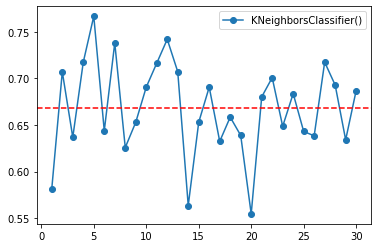

In [50]:
validacion_cruzada(KNeighborsClassifier(), x, y, "f1_macro")

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83       141
         1.0       0.70      0.76      0.73        82

    accuracy                           0.79       223
   macro avg       0.78      0.79      0.78       223
weighted avg       0.80      0.79      0.80       223



(77.4, 79.37)

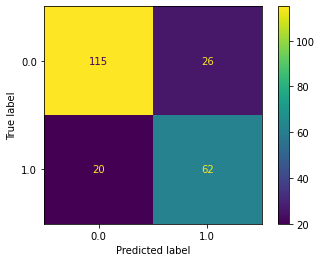

In [51]:
modelo_clasificacion(GaussianNB(), x_train, y_train, x_test, y_test)

(0.7635485399888354, 4.613753920286595)

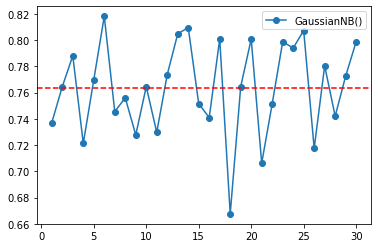

In [52]:
validacion_cruzada(GaussianNB(), x, y, "f1_macro")

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83       141
         1.0       0.71      0.74      0.73        82

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.80      0.79      0.79       223



(78.14, 79.37)

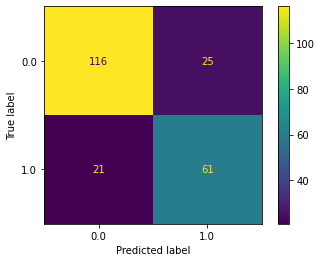

In [53]:
modelo_clasificacion(BernoulliNB(), x_train, y_train, x_test, y_test)

(0.7701363015534607, 6.040214609545223)

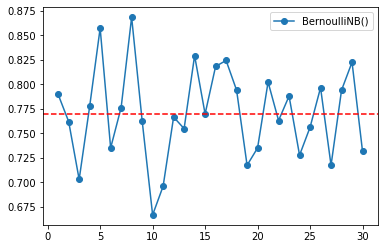

In [54]:
validacion_cruzada(BernoulliNB(), x, y, "f1_macro")

              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       141
         1.0       0.78      0.74      0.76        82

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.83      0.83      0.83       223



(99.1, 82.96)

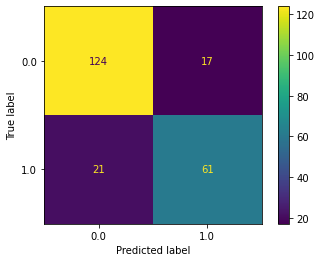

In [55]:
modelo_clasificacion(DecisionTreeClassifier(), x_train, y_train, x_test, y_test)

(0.7644622194646803, 4.675389350396925)

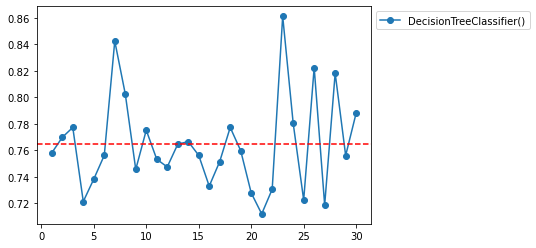

In [56]:
validacion_cruzada(DecisionTreeClassifier(), x, y, "f1_macro")

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       141
         1.0       0.77      0.73      0.75        82

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



(98.95, 82.06)

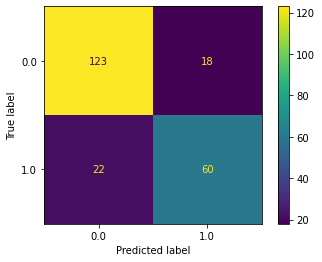

In [57]:
modelo_clasificacion(RandomForestClassifier(), x_train, y_train, x_test, y_test)

(0.8067902487711026, 5.800951070887767)

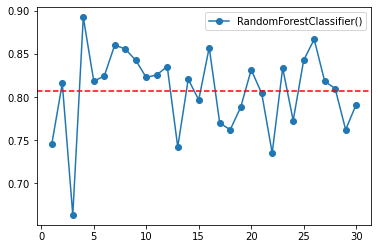

In [58]:
validacion_cruzada(RandomForestClassifier(), x, y, "f1_macro")

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86       141
         1.0       0.75      0.79      0.77        82

    accuracy                           0.83       223
   macro avg       0.81      0.82      0.81       223
weighted avg       0.83      0.83      0.83       223



(99.1, 82.51)

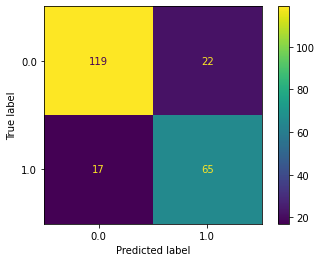

In [59]:
modelo_clasificacion(ExtraTreesClassifier(), x_train, y_train, x_test, y_test)

(0.7915253606613796, 6.6038846897840395)

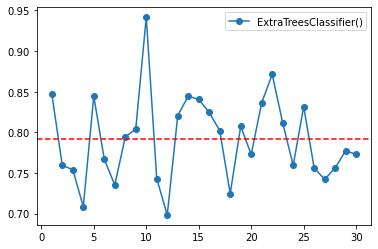

In [60]:
validacion_cruzada(ExtraTreesClassifier(), x, y, "f1_macro")

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       141
         1.0       0.77      0.70      0.73        82

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.81      0.81      0.81       223



(82.49, 81.17)

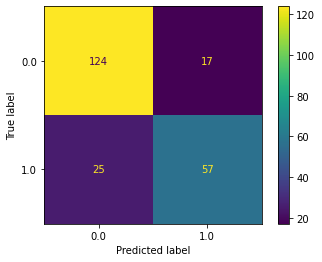

In [61]:
modelo_clasificacion(SVC(), x_train, y_train, x_test, y_test)

(0.5918247277945811, 11.38799796572713)

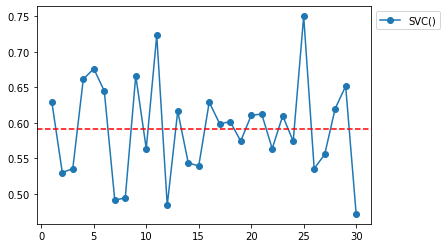

In [62]:
validacion_cruzada(SVC(), x, y, "f1_macro")

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       141
         1.0       0.78      0.76      0.77        82

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223



(98.2, 82.96)

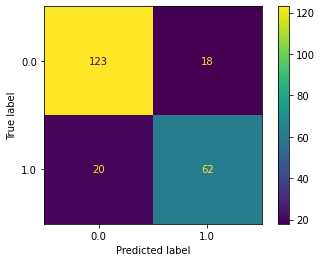

In [63]:
modelo_clasificacion(XGBClassifier(), x_train, y_train, x_test, y_test)

(0.8154563914289354, 4.8073072938937065)

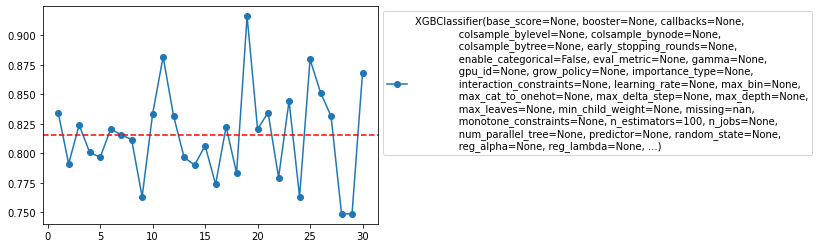

In [64]:
validacion_cruzada(XGBClassifier(), x, y, "f1_macro")

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       141
         1.0       0.71      0.71      0.71        82

    accuracy                           0.78       223
   macro avg       0.77      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223



C:\Users\acast\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(82.63, 78.48)

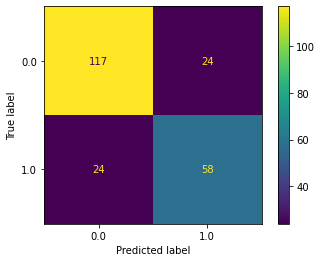

In [65]:
modelo_clasificacion(MLPClassifier(), x_train, y_train, x_test, y_test)

(0.6745954749716077, 14.47810405215611)

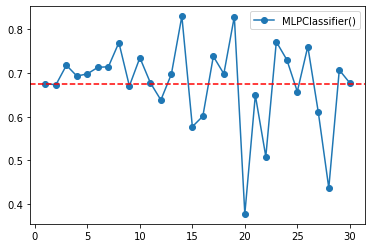

In [66]:
validacion_cruzada(MLPClassifier(), x, y, "f1_macro")

Model  f1_score_macro  COV [%]
8                XGBoost           0.806    6.009
5          Random Forest           0.804    5.724
6  Extra Tree Classifier           0.798    6.179
0   Logistic Regression            0.785    6.208
4    Decision Classifier           0.778    4.396
3  Naive Bayes Bernoulli           0.770    5.236
2   Naive Bayes Gaussian           0.765    5.275
1                    KNN           0.673    6.774
9         MLP Classifier           0.651   13.002
7                    SVC           0.600    9.677

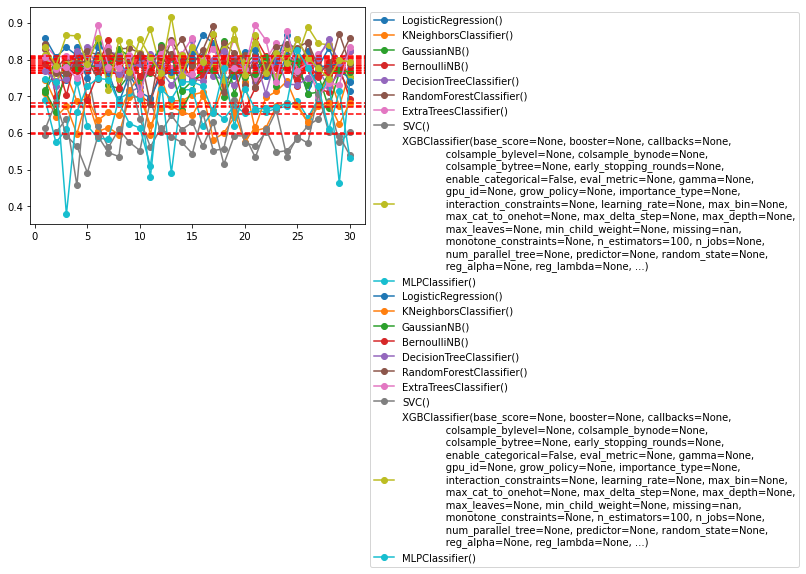

In [67]:
## Comparativa

models = pd.DataFrame({
    'Model': ["Logistic Regression ",
             "KNN",
             "Naive Bayes Gaussian",
             "Naive Bayes Bernoulli",
              "Decision Classifier",
              "Random Forest",
              "Extra Tree Classifier",
             "SVC",
              "XGBoost",
             "MLP Classifier"],

    'f1_score_macro': [validacion_cruzada(LogisticRegression(), x, y, "f1_macro")[0],
             validacion_cruzada(KNeighborsClassifier(), x, y, "f1_macro")[0],
             validacion_cruzada(GaussianNB(), x, y, "f1_macro")[0],
             validacion_cruzada(BernoulliNB(), x, y, "f1_macro")[0],
             validacion_cruzada(DecisionTreeClassifier(), x, y, "f1_macro")[0],
             validacion_cruzada(RandomForestClassifier(), x, y, "f1_macro")[0],
             validacion_cruzada(ExtraTreesClassifier(), x, y, "f1_macro")[0],
             validacion_cruzada(SVC(), x, y, "f1_macro")[0],
             validacion_cruzada(XGBClassifier(), x, y, "f1_macro")[0],
             validacion_cruzada(MLPClassifier(), x, y, "f1_macro")[0]],
             
      'COV [%]': [validacion_cruzada(LogisticRegression(), x, y, "f1_macro")[1],
             validacion_cruzada(KNeighborsClassifier(), x, y, "f1_macro")[1],
             validacion_cruzada(GaussianNB(), x, y, "f1_macro")[1],
             validacion_cruzada(BernoulliNB(), x, y, "f1_macro")[1],
             validacion_cruzada(DecisionTreeClassifier(), x, y, "f1_macro")[1],
             validacion_cruzada(RandomForestClassifier(), x, y, "f1_macro")[1],
             validacion_cruzada(ExtraTreesClassifier(), x, y, "f1_macro")[1],
             validacion_cruzada(SVC(), x, y, "f1_macro")[1],
             validacion_cruzada(XGBClassifier(), x, y, "f1_macro")[1], 
             validacion_cruzada(MLPClassifier(), x, y, "f1_macro")[1]]})

             
models.sort_values(by = 'f1_score_macro', ascending = False)

Based on above results the best classification models based on the f1-macro score metric was

* XGBoost Classifier
* Random Forest Classifier
* Extra Tree Classifier	
* Decision Tree Classifier

In order to get the best performance in the classification process a *hyperparameter tuning* is developed using **Optuna** library

[(0.779049676394862, 5.42472550635621),
 (0.8054194102895165, 4.379857201460037),
 (0.7974496698814001, 5.39698277306361),
 (0.8042938497041463, 5.2012172355659665)]

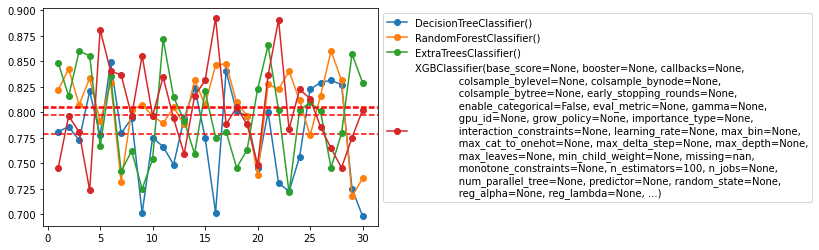

In [68]:
pre_tuning = []

pre_tuning.append(validacion_cruzada(DecisionTreeClassifier(), x, y, "f1_macro"))
pre_tuning.append(validacion_cruzada(RandomForestClassifier(), x, y, "f1_macro"))
pre_tuning.append(validacion_cruzada(ExtraTreesClassifier(), x, y, "f1_macro"))
pre_tuning.append(validacion_cruzada(XGBClassifier(), x, y, "f1_macro"))

pre_tuning

In [69]:
# Función de Sintonización

def op_DT (trial):

    _criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    _splitter = trial.suggest_categorical("splitter", ["best", "random"])
    _max_depth = trial.suggest_categorical("max_depth", [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    _min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    model = DecisionTreeClassifier(criterion = _criterion,
                                 splitter= _splitter,
                                 max_depth = _max_depth,
                                 min_samples_leaf = _min_samples_leaf)
  
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)

    return cross_val_score(model, x, y, scoring = "f1_macro", cv = cv, n_jobs=-1).mean()

study_DT = optuna.create_study(direction = 'maximize')
study_DT.optimize(op_DT, n_trials = 100)

trial = study_DT.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-22 23:10:04,909] A new study created in memory with name: no-name-d6480609-12a4-47f7-8431-f584a31ca21b
[I 2023-03-22 23:10:04,970] Trial 0 finished with value: 0.7681729384392609 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 80, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7681729384392609.
[I 2023-03-22 23:10:05,019] Trial 1 finished with value: 0.8011097031930318 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 40, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8011097031930318.
[I 2023-03-22 23:10:05,069] Trial 2 finished with value: 0.8021723246811536 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8021723246811536.
[I 2023-03-22 23:10:05,149] Trial 3 finished with value: 0.7975431041283112 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 60, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.8

[I 2023-03-22 23:10:07,370] Trial 34 finished with value: 0.8079153443138661 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_leaf': 6}. Best is trial 10 with value: 0.8138524690101941.
[I 2023-03-22 23:10:07,439] Trial 35 finished with value: 0.7950478495541639 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.8138524690101941.
[I 2023-03-22 23:10:07,520] Trial 36 finished with value: 0.7918344643848126 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 80, 'min_samples_leaf': 6}. Best is trial 10 with value: 0.8138524690101941.
[I 2023-03-22 23:10:07,601] Trial 37 finished with value: 0.8065193237627998 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.8138524690101941.
[I 2023-03-22 23:10:07,669] Trial 38 finished with value: 0.7865932320321493 and parameters

[I 2023-03-22 23:10:10,024] Trial 69 finished with value: 0.8029887194249117 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.8138524690101941.
[I 2023-03-22 23:10:10,113] Trial 70 finished with value: 0.7872990484846341 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.8138524690101941.
[I 2023-03-22 23:10:10,207] Trial 71 finished with value: 0.8054156356389425 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.8138524690101941.
[I 2023-03-22 23:10:10,326] Trial 72 finished with value: 0.8069635241793406 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.8138524690101941.
[I 2023-03-22 23:10:10,439] Trial 73 finished with value: 0.79516647125917 and parameters:

Accuracy: 0.8138524690101941
Best hyperparameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_leaf': 6}


In [70]:
optuna.visualization.plot_optimization_history(study_DT)

[(0.7995737481576164, 5.212414906510722)]

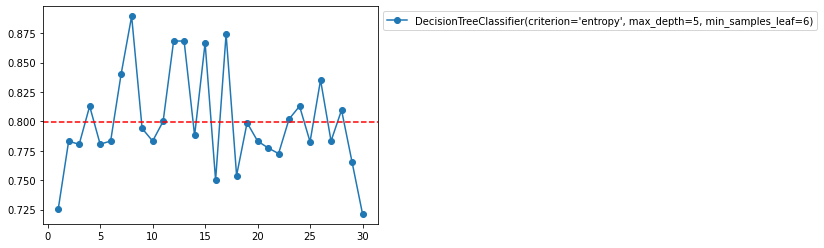

In [71]:

post_tuning = []


_criterion_DT = trial.params["criterion"]
_splitter_DT = trial.params["splitter"]
_max_depth_DT = trial.params["max_depth"]
_min_samples_leaf_DT = trial.params["min_samples_leaf"]

post_tuning.append(validacion_cruzada(DecisionTreeClassifier(criterion = _criterion_DT, 
                                                         splitter = _splitter_DT,
                                                         max_depth = _max_depth_DT,
                                                         min_samples_leaf = _min_samples_leaf_DT), x, y, "f1_macro"))

post_tuning

In [72]:
def op_RF (trial):

    _n_estimators = trial.suggest_int("n_estimators", 10, 100)
    _criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    _max_depth = trial.suggest_int("max_depth", 1, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = RandomForestClassifier(n_estimators = _n_estimators,
                                criterion = _criterion,
                                max_depth = _max_depth,
                                min_samples_leaf = _min_samples_leaf)
  
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)

    return cross_val_score(model, x, y, scoring = "f1_macro", cv = cv, n_jobs=-1).mean()

study_RF = optuna.create_study(direction = 'maximize')
study_RF.optimize(op_RF, n_trials = 30)

trial = study_RF.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-22 23:10:12,609] A new study created in memory with name: no-name-cbaa7c85-74a6-4569-af14-d5a0f7b3ed6f
[I 2023-03-22 23:10:12,945] Trial 0 finished with value: 0.7801349222479579 and parameters: {'n_estimators': 19, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7801349222479579.
[I 2023-03-22 23:10:13,487] Trial 1 finished with value: 0.802261964784346 and parameters: {'n_estimators': 67, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.802261964784346.
[I 2023-03-22 23:10:13,957] Trial 2 finished with value: 0.7083298027615116 and parameters: {'n_estimators': 56, 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.802261964784346.
[I 2023-03-22 23:10:14,347] Trial 3 finished with value: 0.820532900460824 and parameters: {'n_estimators': 41, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.82053290046082

Accuracy: 0.8230265874241708
Best hyperparameters: {'n_estimators': 42, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1}


In [73]:

optuna.visualization.plot_optimization_history(study_RF)

[(0.7995737481576164, 5.212414906510722),
 (0.8165985216833622, 5.237424266781436)]

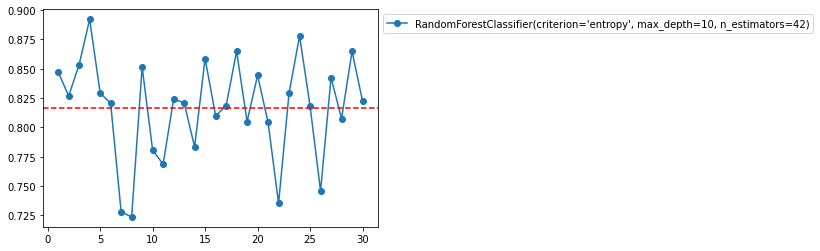

In [74]:
# Valores de desempeño post-tuning

_n_estimators_RF = trial.params["n_estimators"]
_criterion_RF = trial.params["criterion"]
_max_depth_RF = trial.params["max_depth"]
_min_samples_leaf_RF = trial.params["min_samples_leaf"]

post_tuning.append(validacion_cruzada(RandomForestClassifier(n_estimators = _n_estimators_RF,
                                                             criterion = _criterion_RF,
                                                             max_depth = _max_depth_RF,
                                                             min_samples_leaf = _min_samples_leaf_RF), x, y, "f1_macro"))

post_tuning

In [75]:
def op_ET (trial):

    _n_estimators = trial.suggest_int("n_estimators", 10, 100)
    _criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    _max_depth = trial.suggest_int("max_depth", 1, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = ExtraTreesClassifier(n_estimators = _n_estimators,
                                criterion = _criterion,
                                max_depth = _max_depth,
                                min_samples_leaf = _min_samples_leaf)
  
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)

    return cross_val_score(model, x, y, scoring = "f1_macro", cv = cv, n_jobs=-1).mean()

study_ET = optuna.create_study(direction = 'maximize')
study_ET.optimize(op_ET, n_trials = 30)

trial = study_ET.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-22 23:10:29,625] A new study created in memory with name: no-name-2c85cd05-f5f4-44ab-a519-82a7ef8809fe
[I 2023-03-22 23:10:29,863] Trial 0 finished with value: 0.6885194372840449 and parameters: {'n_estimators': 32, 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6885194372840449.
[I 2023-03-22 23:10:30,240] Trial 1 finished with value: 0.7795157552183183 and parameters: {'n_estimators': 41, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7795157552183183.
[I 2023-03-22 23:10:30,723] Trial 2 finished with value: 0.7755958229676324 and parameters: {'n_estimators': 82, 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.7795157552183183.
[I 2023-03-22 23:10:31,018] Trial 3 finished with value: 0.7794328787011436 and parameters: {'n_estimators': 40, 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7795157552183

Accuracy: 0.8121617724980343
Best hyperparameters: {'n_estimators': 26, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1}


In [76]:
optuna.visualization.plot_optimization_history(study_ET)

[(0.7995737481576164, 5.212414906510722),
 (0.8165985216833622, 5.237424266781436),
 (0.8120186553383593, 5.467899357378796)]

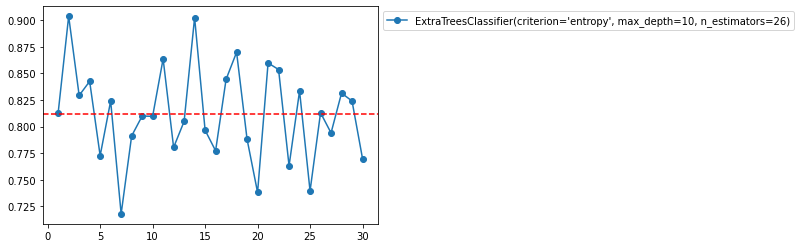

In [77]:
_n_estimators_ET = trial.params["n_estimators"]
_criterion_ET = trial.params["criterion"]
_max_depth_ET = trial.params["max_depth"]
_min_samples_leaf_ET = trial.params["min_samples_leaf"]

post_tuning.append(validacion_cruzada(ExtraTreesClassifier(n_estimators = _n_estimators_ET,
                                                             criterion = _criterion_ET,
                                                             max_depth = _max_depth_ET,
                                                             min_samples_leaf = _min_samples_leaf_ET), x, y, "f1_macro"))

post_tuning

In [78]:
def op_XG (trial):

    _booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
    _eta = trial.suggest_float("eta", 0.01, 0.5)
    _gamma = trial.suggest_int("gamma", 1, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 10)
    _subsample = trial.suggest_float("subsample", 0.1, 1)

    model = XGBClassifier(booster = _booster,
                        eta = _eta,
                        gamma = _gamma,
                        max_depth = _max_depth,
                        subsample = _subsample)
  
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    
    return cross_val_score(model, x, y, scoring = "f1_macro", cv = cv, n_jobs=-1).mean()

study_XG = optuna.create_study(direction = 'maximize')
study_XG.optimize(op_XG, n_trials = 30)

trial = study_XG.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-22 23:10:38,639] A new study created in memory with name: no-name-bd20531a-50a2-4d53-b4d2-8482e8ed19be
[I 2023-03-22 23:10:38,947] Trial 0 finished with value: 0.7665977842538806 and parameters: {'booster': 'gblinear', 'eta': 0.2501292006204245, 'gamma': 70, 'max_depth': 7, 'subsample': 0.4527591709830209}. Best is trial 0 with value: 0.7665977842538806.
[I 2023-03-22 23:10:39,198] Trial 1 finished with value: 0.7720906804020949 and parameters: {'booster': 'gblinear', 'eta': 0.3642284078839454, 'gamma': 99, 'max_depth': 9, 'subsample': 0.8550745921125497}. Best is trial 1 with value: 0.7720906804020949.
[I 2023-03-22 23:10:39,672] Trial 2 finished with value: 0.8119924846423847 and parameters: {'booster': 'gbtree', 'eta': 0.3721758988315692, 'gamma': 3, 'max_depth': 5, 'subsample': 0.2587630591768453}. Best is trial 2 with value: 0.8119924846423847.
[I 2023-03-22 23:10:41,187] Trial 3 finished with value: 0.7526110007343381 and parameters: {'booster': 'dart', 'eta': 0.455253

Accuracy: 0.8119924846423847
Best hyperparameters: {'booster': 'gbtree', 'eta': 0.3721758988315692, 'gamma': 3, 'max_depth': 5, 'subsample': 0.2587630591768453}


In [79]:
optuna.visualization.plot_optimization_history(study_XG)

[(0.7995737481576164, 5.212414906510722),
 (0.8165985216833622, 5.237424266781436),
 (0.8120186553383593, 5.467899357378796),
 (0.8074471304224404, 6.063143906505529)]

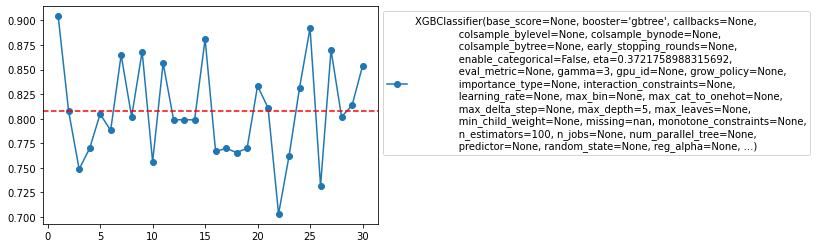

In [80]:
_booster = trial.params["booster"]
_eta = trial.params["eta"]
_gamma = trial.params["gamma"]
_max_depth = trial.params["max_depth"]
_subsample = trial.params["subsample"]


post_tuning.append(validacion_cruzada(XGBClassifier(booster = _booster,
                                                    eta = _eta,
                                                    gamma = _gamma,
                                                    max_depth = _max_depth,
                                                    subsample = _subsample), x, y, "f1_macro"))

post_tuning

In [81]:
# Comparativa

modelos = pd.DataFrame({
    'Model': ["Decision Tree Classifier",
              "Random Forest",
              "Extra Tree Classifier",
              "XGBoost"],

    'Pre-Tuning': [pre_tuning[0][0],
                   pre_tuning[1][0],
                   pre_tuning[2][0],
                   pre_tuning[3][0]],
                   
    'Post-Tuning': [post_tuning[0][0],
                   post_tuning[1][0],
                   post_tuning[2][0],
                   post_tuning[3][0]]})

             
modelos

Model  Pre-Tuning  Post-Tuning
0  Decision Tree Classifier       0.779        0.800
1             Random Forest       0.805        0.817
2     Extra Tree Classifier       0.797        0.812
3                   XGBoost       0.804        0.807

So, the best classification model after the hyperparameter tuning is **XGBoost Classifier**. 

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       141
         1.0       0.77      0.78      0.78        82

    accuracy                           0.83       223
   macro avg       0.82      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223



(87.57, 83.41)

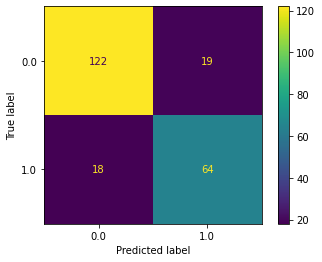

In [82]:
modelo_clasificacion(XGBClassifier(booster = _booster,
                            eta = _eta,
                            gamma = _gamma,
                            max_depth = _max_depth,
                            subsample = _subsample),
                     x_train, y_train, x_test, y_test)

This final model has a little bit of overfitting, but it still performs well with the test set.

Finally, as we have seen above the **Survived** column is unbalanced. So we can use libraries such as **Smote** in order to balance the data set and analyze if the performance of the classification models is better.

<AxesSubplot:ylabel='count'>

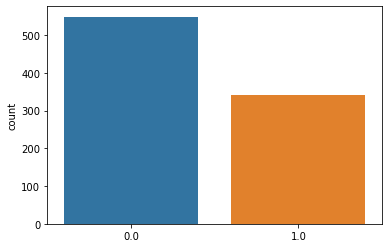

In [83]:
# Unbalanced data

sns.countplot(x = y)

In [84]:
sm = SMOTE()
x, y = sm.fit_resample(x, y)

<AxesSubplot:ylabel='count'>

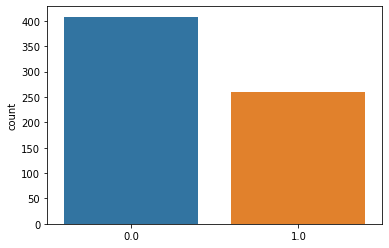

In [85]:
# Balanced data

sns.countplot(x = y_train)

[(0.8178986918434131, 3.4256937445685245),
 (0.8516653356035392, 4.016358483871751),
 (0.8473681593949624, 2.9935945015564838),
 (0.8546868105177897, 4.587103970598971)]

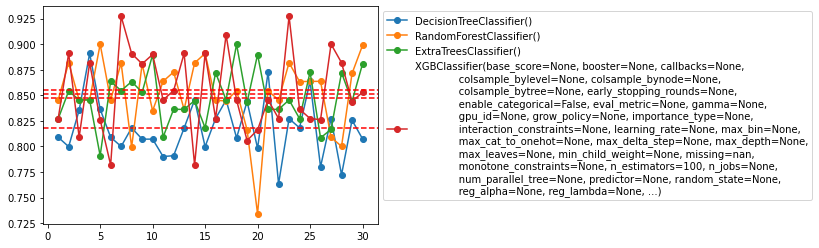

In [86]:
pre_tuning = []

pre_tuning.append(validacion_cruzada(DecisionTreeClassifier(), x, y, "f1_macro"))
pre_tuning.append(validacion_cruzada(RandomForestClassifier(), x, y, "f1_macro"))
pre_tuning.append(validacion_cruzada(ExtraTreesClassifier(), x, y, "f1_macro"))
pre_tuning.append(validacion_cruzada(XGBClassifier(), x, y, "f1_macro"))

pre_tuning

In [87]:
# Función de Sintonización

def op_DT (trial):

    _criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    _splitter = trial.suggest_categorical("splitter", ["best", "random"])
    _max_depth = trial.suggest_categorical("max_depth", [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    _min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    model = DecisionTreeClassifier(criterion = _criterion,
                                 splitter= _splitter,
                                 max_depth = _max_depth,
                                 min_samples_leaf = _min_samples_leaf)
  
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)

    return cross_val_score(model, x, y, scoring = "f1_macro", cv = cv, n_jobs=-1).mean()

study_DT = optuna.create_study(direction = 'maximize')
study_DT.optimize(op_DT, n_trials = 100)

trial = study_DT.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-22 23:11:14,144] A new study created in memory with name: no-name-a4e9bbf0-addc-47c6-8f37-11324c3d555e
[I 2023-03-22 23:11:14,203] Trial 0 finished with value: 0.8121510281159718 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 70, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8121510281159718.
[I 2023-03-22 23:11:14,257] Trial 1 finished with value: 0.8052457665342153 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 70, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8121510281159718.
[I 2023-03-22 23:11:14,311] Trial 2 finished with value: 0.8117192661550221 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 70, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8121510281159718.
[I 2023-03-22 23:11:14,363] Trial 3 finished with value: 0.7931069783498261 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 100, 'min_samples_leaf': 8}. Best is trial 0 with val

[I 2023-03-22 23:11:16,302] Trial 34 finished with value: 0.7990819415300461 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 70, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8300059149300718.
[I 2023-03-22 23:11:16,354] Trial 35 finished with value: 0.8308591111733221 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 50, 'min_samples_leaf': 3}. Best is trial 35 with value: 0.8308591111733221.
[I 2023-03-22 23:11:16,406] Trial 36 finished with value: 0.8199083483424423 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 50, 'min_samples_leaf': 3}. Best is trial 35 with value: 0.8308591111733221.
[I 2023-03-22 23:11:16,460] Trial 37 finished with value: 0.8161658843304197 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 50, 'min_samples_leaf': 3}. Best is trial 35 with value: 0.8308591111733221.
[I 2023-03-22 23:11:16,513] Trial 38 finished with value: 0.7981461831814752 and parameters:

[I 2023-03-22 23:11:18,209] Trial 69 finished with value: 0.8266637374893666 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 90, 'min_samples_leaf': 3}. Best is trial 47 with value: 0.8314896810063768.
[I 2023-03-22 23:11:18,264] Trial 70 finished with value: 0.7954459298470252 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 90, 'min_samples_leaf': 10}. Best is trial 47 with value: 0.8314896810063768.
[I 2023-03-22 23:11:18,318] Trial 71 finished with value: 0.8207453186109781 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 90, 'min_samples_leaf': 4}. Best is trial 47 with value: 0.8314896810063768.
[I 2023-03-22 23:11:18,370] Trial 72 finished with value: 0.8326233276205345 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 80, 'min_samples_leaf': 4}. Best is trial 72 with value: 0.8326233276205345.
[I 2023-03-22 23:11:18,424] Trial 73 finished with value: 0.8336725942872735 and parameters: {

Accuracy: 0.8336725942872735
Best hyperparameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 30, 'min_samples_leaf': 4}


In [88]:
optuna.visualization.plot_optimization_history(study_DT)

[(0.8266373598949432, 4.668243343344631)]

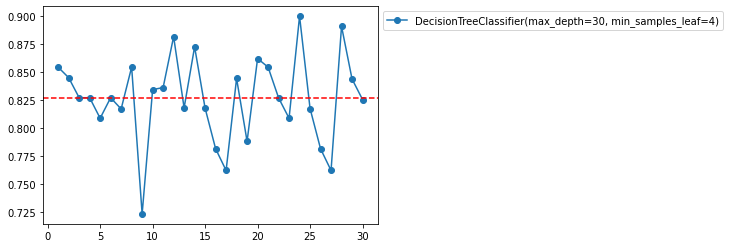

In [89]:

post_tuning = []


_criterion_DT = trial.params["criterion"]
_splitter_DT = trial.params["splitter"]
_max_depth_DT = trial.params["max_depth"]
_min_samples_leaf_DT = trial.params["min_samples_leaf"]

post_tuning.append(validacion_cruzada(DecisionTreeClassifier(criterion = _criterion_DT, 
                                                         splitter = _splitter_DT,
                                                         max_depth = _max_depth_DT,
                                                         min_samples_leaf = _min_samples_leaf_DT), x, y, "f1_macro"))

post_tuning

In [90]:
def op_RF (trial):

    _n_estimators = trial.suggest_int("n_estimators", 10, 100)
    _criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    _max_depth = trial.suggest_int("max_depth", 1, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = RandomForestClassifier(n_estimators = _n_estimators,
                                criterion = _criterion,
                                max_depth = _max_depth,
                                min_samples_leaf = _min_samples_leaf)
  
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)

    return cross_val_score(model, x, y, scoring = "f1_macro", cv = cv, n_jobs=-1).mean()

study_RF = optuna.create_study(direction = 'maximize')
study_RF.optimize(op_RF, n_trials = 30)

trial = study_RF.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-22 23:11:20,111] A new study created in memory with name: no-name-a78d7e52-1e07-46ec-b2a9-2eab61c821a8
[I 2023-03-22 23:11:20,316] Trial 0 finished with value: 0.8310763270467056 and parameters: {'n_estimators': 16, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8310763270467056.
[I 2023-03-22 23:11:21,267] Trial 1 finished with value: 0.8383023405802306 and parameters: {'n_estimators': 93, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8383023405802306.
[I 2023-03-22 23:11:22,043] Trial 2 finished with value: 0.8458278341769364 and parameters: {'n_estimators': 80, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8458278341769364.
[I 2023-03-22 23:11:22,450] Trial 3 finished with value: 0.7973212144157115 and parameters: {'n_estimators': 56, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.8458278

Accuracy: 0.8558841413801294
Best hyperparameters: {'n_estimators': 49, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1}


In [91]:

optuna.visualization.plot_optimization_history(study_RF)

[(0.8266373598949432, 4.668243343344631),
 (0.8478393902166191, 3.3369404292021447)]

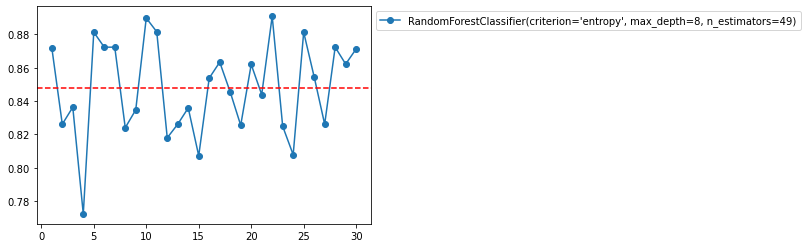

In [92]:
# Valores de desempeño post-tuning

_n_estimators_RF = trial.params["n_estimators"]
_criterion_RF = trial.params["criterion"]
_max_depth_RF = trial.params["max_depth"]
_min_samples_leaf_RF = trial.params["min_samples_leaf"]

post_tuning.append(validacion_cruzada(RandomForestClassifier(n_estimators = _n_estimators_RF,
                                                             criterion = _criterion_RF,
                                                             max_depth = _max_depth_RF,
                                                             min_samples_leaf = _min_samples_leaf_RF), x, y, "f1_macro"))

post_tuning

In [93]:
def op_ET (trial):

    _n_estimators = trial.suggest_int("n_estimators", 10, 100)
    _criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    _max_depth = trial.suggest_int("max_depth", 1, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = ExtraTreesClassifier(n_estimators = _n_estimators,
                                criterion = _criterion,
                                max_depth = _max_depth,
                                min_samples_leaf = _min_samples_leaf)
  
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)

    return cross_val_score(model, x, y, scoring = "f1_macro", cv = cv, n_jobs=-1).mean()

study_ET = optuna.create_study(direction = 'maximize')
study_ET.optimize(op_ET, n_trials = 30)

trial = study_ET.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-22 23:11:37,579] A new study created in memory with name: no-name-4d953705-aba2-4877-bde2-b1a5f9a4eab6
[I 2023-03-22 23:11:37,920] Trial 0 finished with value: 0.7786492472068841 and parameters: {'n_estimators': 64, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7786492472068841.
[I 2023-03-22 23:11:38,320] Trial 1 finished with value: 0.8325488817346614 and parameters: {'n_estimators': 61, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8325488817346614.
[I 2023-03-22 23:11:38,480] Trial 2 finished with value: 0.8002235294433724 and parameters: {'n_estimators': 21, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8325488817346614.
[I 2023-03-22 23:11:38,783] Trial 3 finished with value: 0.8000551820201928 and parameters: {'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.832548881

Accuracy: 0.8449391910025249
Best hyperparameters: {'n_estimators': 43, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}


In [94]:
optuna.visualization.plot_optimization_history(study_ET)

[(0.8266373598949432, 4.668243343344631),
 (0.8478393902166191, 3.3369404292021447),
 (0.8463515578459525, 4.493402352258242)]

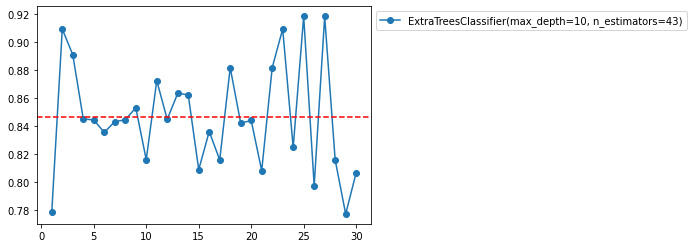

In [95]:
_n_estimators_ET = trial.params["n_estimators"]
_criterion_ET = trial.params["criterion"]
_max_depth_ET = trial.params["max_depth"]
_min_samples_leaf_ET = trial.params["min_samples_leaf"]

post_tuning.append(validacion_cruzada(ExtraTreesClassifier(n_estimators = _n_estimators_ET,
                                                             criterion = _criterion_ET,
                                                             max_depth = _max_depth_ET,
                                                             min_samples_leaf = _min_samples_leaf_ET), x, y, "f1_macro"))

post_tuning

In [96]:
def op_XG (trial):

    _booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
    _eta = trial.suggest_float("eta", 0.01, 0.5)
    _gamma = trial.suggest_int("gamma", 1, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 10)
    _subsample = trial.suggest_float("subsample", 0.1, 1)

    model = XGBClassifier(booster = _booster,
                        eta = _eta,
                        gamma = _gamma,
                        max_depth = _max_depth,
                        subsample = _subsample)
  
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    
    return cross_val_score(model, x, y, scoring = "f1_macro", cv = cv, n_jobs=-1).mean()

study_XG = optuna.create_study(direction = 'maximize')
study_XG.optimize(op_XG, n_trials = 30)

trial = study_XG.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-22 23:11:47,722] A new study created in memory with name: no-name-708ae0eb-aa17-4c97-bbb6-844d71940094
[I 2023-03-22 23:11:49,743] Trial 0 finished with value: 0.7959875778294968 and parameters: {'booster': 'dart', 'eta': 0.2940509164707048, 'gamma': 87, 'max_depth': 10, 'subsample': 0.9820001795148074}. Best is trial 0 with value: 0.7959875778294968.
[I 2023-03-22 23:11:50,661] Trial 1 finished with value: 0.7960564994634638 and parameters: {'booster': 'gbtree', 'eta': 0.31677108516142766, 'gamma': 74, 'max_depth': 9, 'subsample': 0.9659123591684541}. Best is trial 1 with value: 0.7960564994634638.
[I 2023-03-22 23:11:50,912] Trial 2 finished with value: 0.7710656168448992 and parameters: {'booster': 'gblinear', 'eta': 0.3278219101629941, 'gamma': 14, 'max_depth': 7, 'subsample': 0.34147689173133644}. Best is trial 1 with value: 0.7960564994634638.
[I 2023-03-22 23:11:51,585] Trial 3 finished with value: 0.7960512813408709 and parameters: {'booster': 'gbtree', 'eta': 0.2027

Accuracy: 0.8584612184783208
Best hyperparameters: {'booster': 'dart', 'eta': 0.2540165157877421, 'gamma': 3, 'max_depth': 8, 'subsample': 0.8866056419913734}


In [97]:
optuna.visualization.plot_optimization_history(study_XG)

[(0.8266373598949432, 4.668243343344631),
 (0.8478393902166191, 3.3369404292021447),
 (0.8463515578459525, 4.493402352258242),
 (0.8551077350785293, 3.526717962757405)]

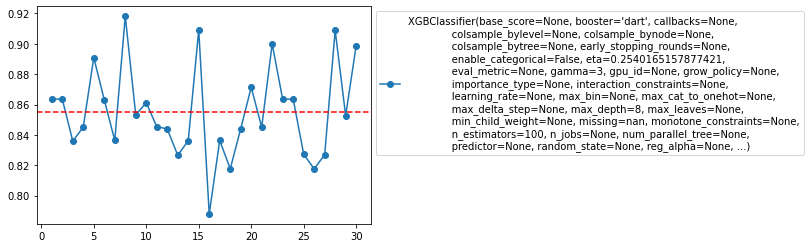

In [98]:
_booster = trial.params["booster"]
_eta = trial.params["eta"]
_gamma = trial.params["gamma"]
_max_depth = trial.params["max_depth"]
_subsample = trial.params["subsample"]


post_tuning.append(validacion_cruzada(XGBClassifier(booster = _booster,
                                                    eta = _eta,
                                                    gamma = _gamma,
                                                    max_depth = _max_depth,
                                                    subsample = _subsample), x, y, "f1_macro"))

post_tuning

In [99]:
# Comparativa

modelos = pd.DataFrame({
    'Model': ["Decision Tree Classifier",
              "Random Forest",
              "Extra Tree Classifier",
              "XGBoost"],

    'Pre-Tuning': [pre_tuning[0][0],
                   pre_tuning[1][0],
                   pre_tuning[2][0],
                   pre_tuning[3][0]],
                   
    'Post-Tuning': [post_tuning[0][0],
                   post_tuning[1][0],
                   post_tuning[2][0],
                   post_tuning[3][0]]})

             
modelos

Model  Pre-Tuning  Post-Tuning
0  Decision Tree Classifier       0.818        0.827
1             Random Forest       0.852        0.848
2     Extra Tree Classifier       0.847        0.846
3                   XGBoost       0.855        0.855

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90       141
         1.0       0.84      0.78      0.81        82

    accuracy                           0.87       223
   macro avg       0.86      0.85      0.85       223
weighted avg       0.86      0.87      0.86       223



(89.52, 86.55)

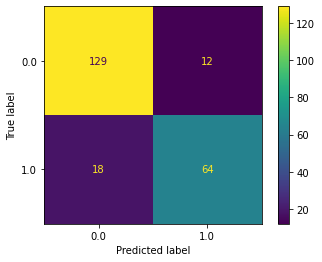

In [100]:
modelo_clasificacion(XGBClassifier(booster = _booster,
                            eta = _eta,
                            gamma = _gamma,
                            max_depth = _max_depth,
                            subsample = _subsample),
                     x_train, y_train, x_test, y_test)

Summarizing the creation of the classification model, the final results are shown below

* *Best classification model based on f1-macro score*: **XGBoost Classifier**
* *Original classification score*: **82.96**
* *Score after hyperparameter tuning*: **83.41**
* *Score after data balancing*: **86.55**